# 勾配

* すべての変数の偏微分をベクトルとしてまとめたもの
* 関数の値を最も減らす方向を指すことができる

In [1]:
import numpy as np

def numerical_gradient(f, x):
    """
    勾配を求めます
    
    Parameters
    ----------
    f : function
        勾配を求めたい、1つの引数を持つ関数
    x : np.array
        一つの引数に与える値の配列
    """
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # 同じ長さ・形状の配列を0で埋めたもの
    
    for idx in range(x.size):
        tmp_val = float(x[idx]) # 元の値を保存する
        # f(x+h) の計算
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h) の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 値を元に戻す
        
    return grad

In [2]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [3]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [4]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [5]:
numerical_gradient(function_2, np.array([3.0, 0.0]))

array([6., 0.])

## 勾配を可視化する

In [6]:
def numerical_gradient_batch(f, X):
    if X.ndim == 1:
        return numerical_gradient(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = numerical_gradient(f, x)
        
        return grad

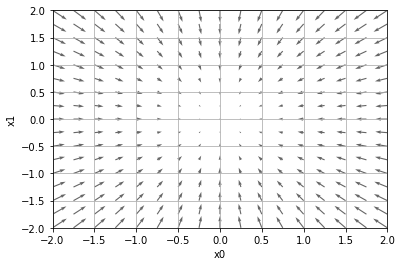

In [7]:
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient_batch(function_2, np.array([X, Y]).T).T

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.draw()
plt.show()

## 勾配法 (gradient method)

* 機械学習では、学習時に最適なパラメータを探索
* ニューラルネットワークでは、重みとバイアスを学習時に探索する
* ニューラルネットワークでの最適なパラメータとは、**損失関数が最小値をとる**とき
* 関数の最小値を探索するために、勾配を使うのが勾配法
  * ただし実際は、複雑な関数になると勾配が指す方向が必ず最小値になるわけではない
  * 最小値、極小値(関数が一番小さい値を返す引数)、鞍点(saddle point)の可能性がある
  * また、「プラトー」と呼ばれる、平坦な値しか出ず学習が進まない場合もある
* 最小値を探す場合を**勾配降下法 (gradient decrent method)**という
* 最大値を探す場合を**勾配上昇法 (gradient ascent method)**という

勾配法 (勾配降下法) の数式は、
* $\eta$(ｲﾀまたはｴｰﾀ) を更新の量
* $\frac{\partial f}{\partial x_0}$ と $\frac{\partial f}{\partial x_1}$は 関数$f(x)$の偏微分
$$
    x_0 = x_0 - \eta\frac{\partial f}{\partial x_0}
$$
$$
    x_1 = x_1 - \eta\frac{\partial f}{\partial x_1}
$$

* 更新の量 $\eta$ はニューラルネットワークの学習において、**学習率 (learning rate)** という
* 学習率の値は事前に決める必要がある
  * 大きすぎても、小さすぎてもだめ
  * 学習率の値を変更しながら、学習できているのかを確認していく必要がある
* 学習率のようなパラメータを、**ハイパーパラメーター**という

In [8]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    """
    勾配法による関数の極小値(または最小値)を求めます
    
    
    Parameters
    ----------
    f : function
        勾配を求めたい、1つの引数を持つ関数
    init_x : np.array
        引数の初期値
    lr : float
        学習率 (learning rate)
    step_num : int
        勾配法による繰り返しの数
    """
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient_batch(f, x)
        x -= lr * grad
        
    return x

$f(x_0, x_1) = x_0^2 + x_1^2$ の最小値を勾配法で求める):

In [9]:
def function_2(x): # 関数の最小値は 0
    return x[0]**2 + x[1]**2

In [10]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

In [11]:
# 学習率が大きいと？
gradient_descent(function_2, init_x, lr=10.0, step_num=100)

array([ 2.34235971e+12, -3.96091057e+12])

In [12]:
# 学習率が小さいと？
gradient_descent(function_2, init_x, lr=1e-10, step_num=100)

array([ 2.34235971e+12, -3.96091057e+12])

## ニューラルネットワークに対する勾配

In [13]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'sample')))
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    """
    勾配法による、ニューラルネットワークの学習
    
    Attributes
    ----------
    W : np.array
        2 × 3 の重みパラメータ
    """
    def __init__(self):
        self.W = np.random.randn(2,3)

    def predict(self, x):
        """
        予測するためのメソッド
        
        Parameters
        ----------
        x : np.array
            入力データ
        """
        return np.dot(x, self.W)

    def loss(self, x, t):
        """
        損失関数の値を求めます
        
        Parameters
        ----------
        x : np.array
            入力データ
        t : np.array
            正解ラベル
        """
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [14]:
net = simpleNet()
print(net.W)

[[-1.99211562  1.14477424 -1.45642822]
 [ 0.87725342 -0.54312004  0.14237287]]


In [15]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-0.4057413   0.19805651 -0.74572135]


In [16]:
np.argmax(p) # 最大値のインデックス

1

In [17]:
t = np.array([0, 0, 1]) # 正解ラベル
net.loss(x, t)

1.6043425589576015

In [18]:
# 勾配を求める
f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.1694514   0.30993542 -0.47938682]
 [ 0.2541771   0.46490313 -0.71908023]]


## 学習アルゴリズムの実装

1. 訓練データを無作為に選択し、そのデータをミニバッチとする
2. ミニバッチの損失関数を減らすために、各重みパラメータの勾配を求める
3. 重みパラメータを勾配方向に、微小値だけ更新する

これを繰り返す

* ミニバッチとして、無作為に選ばれたデータを使用している方法を**確率的勾配降下法 (strochastic gradient descent)** という
* 頭文字をとって**SGD** と呼ばれる関数で実装されるのが一般的、

In [19]:
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:
    """
    2層ニューラルネットワーク
    
    Attributes
    ----------
    params : dictionary object
        ニューラルネットワークで保持する重みとバイアス
    """
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        """
        Parameters
        ----------
        input_size : int
            入力層のニューロンの数
        hidden_size : int
            隠れ層のニューロンの数
        output_size : int
            出力層のニューロンの数
        """
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        """
        推論を行います
        
        Parameters
        ----------
        x : np.array
            画像データ
        """
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    def loss(self, x, t):
        """
        損失関数の値を求めます
        
        Parameters
        ----------
        x : np.array
            画像データ
        t : np.array
            画像データの正解ラベル
        """
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        """
        認識精度を求めます
        
        Parameters
        ----------
        x : np.array
            画像データ
        t : np.array
            画像データの正解ラベル
        """
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def numerical_gradient(self, x, t):
        """
        重みパラメータに対する勾配を求めます
        
        Parameters
        ----------
        x : np.array
            画像データ
        t : np.array
            画像データの正解ラベル
        """
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        """
        重みパラメータに対する勾配を求めます
        numerical_gradient の高速版
        
        Parameters
        ----------
        x : np.array
            画像データ
        t : np.array
            画像データの正解ラベル
        """
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

写経

In [ ]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

print("{0}.shape = {1}".format('W1', net.params['W1'].shape))
print("{0}.shape = {1}".format('b1', net.params['b1'].shape))
print("{0}.shape = {1}".format('W2', net.params['W2'].shape))
print("{0}.shape = {1}".format('b2', net.params['b2'].shape))


# ダミーの入力データ
x = np.random.rand(100, 784)

# ダミーの正解ラベル
t = np.random.rand(100, 10)

# 勾配を計算
grads = net.numerical_gradient(x, t)

print("{0}.shape = {1}".format('grads[W1]', grads['W1'].shape))
print("{0}.shape = {1}".format('grads[b1]', grads['b1'].shape))
print("{0}.shape = {1}".format('grads[W2]', grads['W2'].shape))
print("{0}.shape = {1}".format('grads[b2]', grads['b2'].shape))

W1.shape = (784, 100)
b1.shape = (100,)
W2.shape = (100, 10)
b2.shape = (10,)


## ミニバッチ学習の実装

In [ ]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'sample')))
sys.path.append(os.path.abspath(os.path.join('..', 'sample', 'ch04')))
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = [] # 損失関数の結果
train_acc_list = []  # 学習データの認識精度
test_acc_list = []   # テストデータの認識精度

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 学習経過を損失関数の結果として記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1エポック(訓練データをすべて使い切った回数)ごとに認識精度を計算
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

* 訓練データとテストデータの認識精度が向上しているのがわかる
* 二つの認識精度に差がない = 過学習が起きていない